# Oscilador armónico cuántico
### Método de difusión de Monte Carlo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [80]:
def Potencial(x):
    """
    Energía potencial
    imputs: coordenadas espaciales
    
    outputs: energía potencial 
    """
    return 0.5*x**2

def W(x,ER,dtau):
    """
    Razon bith/dead. Distribución proporcional al número de replicas
    
    inputs: x coordenada espacial
           ER energía de referencia 
            dtau paso de tiempo
    outputs: W(x,ER,dtau) 
            
    
    """
    return np.exp(-dtau*(Potencial(x)-ER))

def mn(x,ER,dtau):
    """ 
    inputs: x coordenada espacial
            ER energía de referencia
            dtau paso de tiempo
    outputs: número entero que cumple una condicion 
    """
    return min(np.append(int(W(x,ER,dtau)+np.random.random()),3))

def bith_dead(x,ER,N,dtau):
    """
    Calcula en nuevo número de replicas tomando en cuenta el valor de la distribución W y de la condición mn. 
    Actualiza el valor de x, elimina o añade valores a x
    
    condicion birth/dead. 
    si mn = 1, no se cambia el número de replicas
    si nm = 0, se elimina un replica 
    si nm = 2,3 se crea 1 o 2 nuevas replicas
    
    inputs: x coordenada espacial
            ER energía de referencia
            dtau paso de tiempo
    outputs: N, nuevo número de replicas 
    """
    for xj in x:
        if mn(xj,ER,dtau) == 0:
            N = N - 1
            x[np.where(x==xj)]=0
        elif mn(xj,ER,dtau) == 2:
            x[N]=x[np.where(x==xj)][0]
            N = N + 1
        elif mn(xj,ER,dtau) == 3:
            x[N]=x[np.where(x==xj)]
            x[N+1]=x[np.where(x==xj)]
            N = N + 2
    return N 

def b_dead(x,ER,N,dtau):
    for ind in range(len(x)):
        
        if mn(x[ind],ER,dtau) == 0:
            x = np.delete(x,ind)
            x = np.append(x,0)
            N = N-1
        elif mn(x[ind],ER,dtau) == 2:
            x = np.append(x,x[ind])
            N = N+1
        elif mn(x[ind],ER,dtau) == 3:
            x = np.append(x,[x[ind],x[ind]])
            N = N+2
    return N 

def energia_ref2(x,N,N0,Nant,dtau):
    """
    Calcula energía de referencia
    
    inputs: x coordenada espacial
            N número de replicas actual
            N0 número de replicas inicial 
            Nant número de replicas anterior 
            dtau paso de tiempo
            
    outputs: ER, energía de referencia 
    """
    if np.abs(N/Nant-1)>0.1:
        return V_avg2(x,N)+0.05*(1-N/N0)
    else:
        return V_avg2(x,N)+0.05*(1-N/Nant)

def V_avg2(x,N):
    """
    Valor de la energía potencial promedio 
    
    inputs: x coordenada espacial
            N número de replicas
            
    outputs: valor promedio 
    """
    xy = No_cero(x)
    return np.sum(Potencial(xy))/N

def No_cero(x):
    """
    Extrae los valores no nulos del vector x
    
    inputs: x coordenada espacial

    outputs: x sin valores nulos 
    """
    xx = []
    j = 0
    for i in x:
        if i!=0:
            xx.append(i)
    xr = np.array(xx)
    return xr


def funciondeonda(xx):
    """
    Estima la función de onda a partir de los valores de x 
    
    inputs: xx coordenada espacial

    outputs: yf estimación de la función de onda 
             xf valores de x, intervalos
    """
    x = No_cero(xx)
    xmin = -4
    xmax =  4
    Num = 50
    dx = (xmax-xmin)/Num
    Nf = []
    xf = []
    for n in range(Num):
        Nn = []
        for i in range(len(x)):
            if ((x[i]< xmin+(n+1)*dx) & (x[i]>xmin+(n)*dx)):
                Nn.append(x[i])
        Nf.append(len(Nn))
        xf.append(xmin+dx*n)
    
    yf = np.array(Nf)/np.max(Nf)*phi0(0)
    
    return yf,xf

def phi0(x):
    """
    función de onda teórica del oscilador armónico en el estado base 
    
    """
    return np.pi**(-0.25)*np.exp(-np.array(x)**2/2)
def graficar(rr):
    plt.title('DMC')
    plt.plot(rr[1],'r.-')
    plt.hlines(0.5,0,len(rr[1]),'g')
    plt.ylabel('Energía Promedio')
    plt.xlabel('Número de pasos de difusión')
    plt.legend(['DMC','$E_0 = 0.5$'])
    #plt.savefig('DMC_Energy_M.jpeg',dpi = 600)
    plt.show()
    
    yf = funciondeonda(rr[0])[0]
    xf = funciondeonda(rr[0])[1]
    plt.plot(xf,yf,'-r')
    plt.plot(xf,phi0(xf),'-g')
    plt.xlabel('x')
    plt.legend(['DMC','$\\Phi_0$'])
    plt.title('Función de Onda')
    #plt.savefig('DMC_WaveFunction_2.jpeg',dpi = 600)
    plt.show()

In [81]:
def main(N0=250,dtau=0.1,timesteps=300):
    """
    Esta función ejecuta la simulación de monte carlo difusiva
    inputs: N0, número de replicas inicial 
            dtau, paso de tiempo
            timesteps, número de iteraciones temporales 
    
    return: x, coordenada x 
            En, vector de enrgías para cada iteración 
            NN, número de replicas para cada iteración 
    
    """
    Nmax = 5000
    
    En = [] # Vectores para almacenar la energía
    NN = [] # Vector que almacen el número de replicas
    x = np.zeros(Nmax) # inicializa el vector en cero 
    
    # Forma de la función de onda inicial, 
    # Se toma una función centrada en cero con distribución normal.
    
    for j in range(N0):
        x[j] =  x[j] + np.random.normal(loc=0,scale=1)*np.sqrt(dtau)
    N = N0
    Nant = N0
    
    # Se calcula la energía de referencia con relación
    ER = energia_ref2(x,N,N0,Nant,dtau)
    
    # Se realiza la evolución temporal difusiva
    
    for steps in range(timesteps):
        
        # condición de llenado del la lista
        if (Nmax - N) < 150:
            xadd = np.zeros(1000)
            x = np.append(x,xadd)
            Nmax = len(x)
            
        if steps > 30:
            dtau = 0.1
        if steps > 100:
            dtau = 0.1
        if steps > 200:
            dtau = 0.1
        Nant = N
        
        #recalcula en nuevo número de partículas a partir del proceso de birth/dead
        N = bith_dead(x,ER,N,dtau)
        for j in range(N):
            x[j] =  x[j] + np.random.normal(loc=0,scale=1)*np.sqrt(dtau)
        
        # recalcula la energía de referencia 
        ER = energia_ref2(x,N,N0,Nant,dtau)
        
        # Añade los valores calculados a una lista
        En.append(V_avg2(x,N))
        NN.append(N)

        """
        plt.plot(En)
        plt.show()
        fig, axs = plt.subplots(2)
        axs[0].plot(En)
        axs[0].hlines(0.5,0,steps)
        axs[1].hist(No_cero(x),200,(-4,4),density=True)
        axs[0].set_title(f'{N} número de particulas, razón {Nant/N}')
        axs[0].set_xlabel('Tau')
        axs[0].set_ylabel('Energy')
        plt.show()
        """
    return x,En,NN

In [ ]:
rr = main()

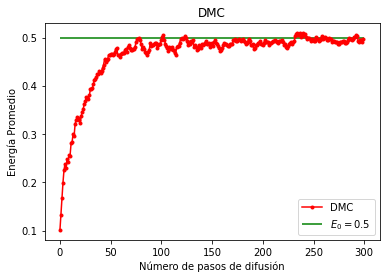

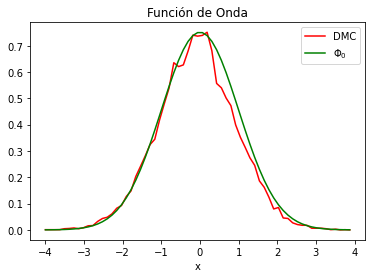

In [64]:
graficar(rr)